In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv')
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [85]:
print("Missing values per column:")
df.isnull().sum()

Missing values per column:


lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [86]:
# Check if the missing values are presented in the features

for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna('NA')
    else:
        df[col] = df[col].fillna(0.0)

print("Missing values per column:")
df.isnull().sum()

Missing values per column:


lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [87]:
# Information of the dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1462 non-null   object 
 1   industry                  1462 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1462 non-null   float64
 4   employment_status         1462 non-null   object 
 5   location                  1462 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


In [88]:
# 3. Split the data into train/validation/test (60%/20%/20%)

df_train, df_temp = train_test_split(df, test_size=0.4, random_state=1)

df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=1)

In [89]:
df_train[['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']]

,lead_score,number_of_courses_viewed,interaction_count,annual_income
340,0.43,3,1,69033.0
596,0.52,3,0,0.0
457,0.87,1,7,68118.0
175,0.53,0,5,65044.0
549,0.89,5,0,48327.0
...,...,...,...,...
715,0.88,2,0,35103.0
905,0.64,1,5,66006.0
1096,0.07,2,2,73688.0
235,0.49,2,3,76723.0


In [90]:
# Q1: ROC AUC feature importance

features = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']

auc_scores = {}

for f in features:
    score = roc_auc_score(y_train, df_train[f])
    
    if score < 0.5:
        score = roc_auc_score(y_train, -df_train[f])
        
    auc_scores[f] = score
    print(f"{f}: {score:.3f}")

best_feature = max(auc_scores, key=auc_scores.get)
print("\nFeature with highest AUC:", best_feature)

lead_score: 0.611
number_of_courses_viewed: 0.765
interaction_count: 0.727
annual_income: 0.545

Feature with highest AUC: number_of_courses_viewed


In [91]:
# Q2: Training the model

y_train = df_train['converted']
y_val = df_val['converted']

X_train = df_train.drop(columns=['converted'])
X_val = df_val.drop(columns=['converted'])

dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(X_train.to_dict(orient='records'))
X_val = dv.transform(X_val.to_dict(orient='records'))

# Train logistic regression
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print(round(auc, 3))

0.794


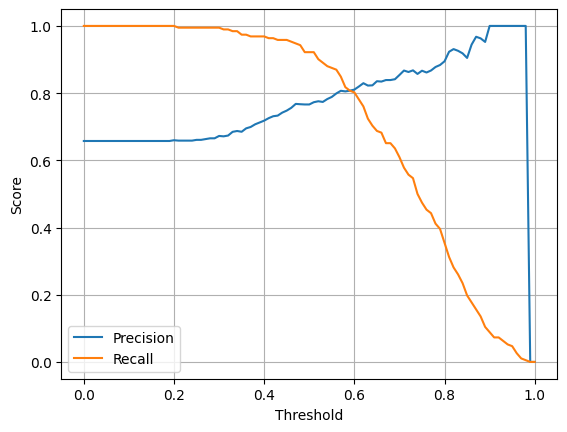

Intersection threshold: 0.59


In [92]:
# Q3: Precision and Recall

y_pred_proba = model.predict_proba(X_val)[:, 1]

thresholds = np.arange(0.0, 1.01, 0.01)
precisions, recalls = [], []

for t in thresholds:
    preds = (y_pred_proba >= t).astype(int)
    precisions.append(precision_score(y_val, preds, zero_division=0))
    recalls.append(recall_score(y_val, preds, zero_division=0))

plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

diff = np.abs(np.array(precisions) - np.array(recalls))
best_t = thresholds[np.argmin(diff)]
print("Intersection threshold:", round(best_t, 3))

In [93]:
# Q4: F1 score

y_pred_proba = model.predict_proba(X_val)[:, 1]

thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

for t in thresholds:
    preds = (y_pred_proba >= t).astype(int)
    p = precision_score(y_val, preds, zero_division=0)
    r = recall_score(y_val, preds, zero_division=0)
    if p + r == 0:
        f1 = 0
    else:
        f1 = 2 * p * r / (p + r)
    f1_scores.append(f1)

best_t = thresholds[np.argmax(f1_scores)]
print("Threshold with highest F1:", round(best_t, 3))

Threshold with highest F1: 0.47


In [94]:
# Q5: 5-Fold CV

df_full_train = pd.concat([df_train, df_val])

# Target and features
y = df_full_train['converted']
X = df_full_train.drop(columns=['converted'])

# 5-Fold CV
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kfold.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    dv = DictVectorizer(sparse=True)
    X_train = dv.fit_transform(X_train.to_dict(orient='records'))
    X_val = dv.transform(X_val.to_dict(orient='records'))

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_val)[:, 1]
    scores.append(roc_auc_score(y_val, y_pred))

print("Standard deviation:", round(np.std(scores), 4))

Standard deviation: 0.022


In [96]:
# Question 6: Hyperparameter Tuning

y = df_full_train['converted'].astype(int)
X = df_full_train.drop(columns=['converted'])

kfold = KFold(n_splits=5, shuffle=True, random_state=1)
Cs = [1e-6, 1e-3, 1]

results = []
for C in Cs:
    scores = []
    for tr_idx, va_idx in kfold.split(X):
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

        dv = DictVectorizer(sparse=True)
        X_tr_dv = dv.fit_transform(X_tr.to_dict(orient='records'))
        X_va_dv = dv.transform(X_va.to_dict(orient='records'))

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_tr_dv, y_tr)

        p = model.predict_proba(X_va_dv)[:, 1]
        scores.append(roc_auc_score(y_va, p))

    mean_auc = round(float(np.mean(scores)), 3)
    std_auc  = round(float(np.std(scores)), 3)
    results.append({'C': C, 'mean': mean_auc, 'std': std_auc})

for r in results:
    print(r)

best = min(results, key=lambda r: (-r['mean'], r['std'], r['C']))
print("\nBest:", best)

{'C': 1e-06, 'mean': 0.543, 'std': 0.025}
{'C': 0.001, 'mean': 0.864, 'std': 0.014}
{'C': 1, 'mean': 0.825, 'std': 0.022}

Best: {'C': 0.001, 'mean': 0.864, 'std': 0.014}
